In [12]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('figure', figsize=(16, 4))

In [22]:
path = 'data/es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise10.flac'                                                  
flac_data, sampling_frequency = sf.read(path)

In [23]:
def convert_flac_to_float(data):
    if data.dtype == np.uint8:
        data = (data - 128) / 128.
    elif data.dtype == np.int16:
        data = data / 32768.
    elif data.dtype == np.int32:
        data = data / 2147483648.
    return data

flac_data = convert_flac_to_float(flac_data)

In [24]:
n_samples = len(flac_data)
total_duration = n_samples / sampling_frequency
sample_times = np.linspace(0, total_duration, n_samples)

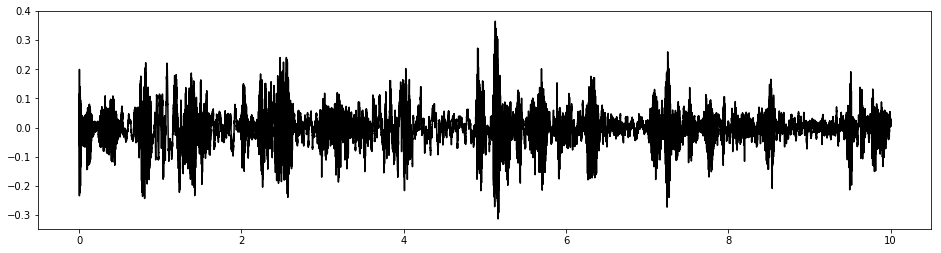

In [26]:
plt.plot(sample_times, flac_data, color='k');

In [27]:
# taken from https://github.com/drammock/spectrogram-tutorial/blob/master/spectrogram.ipynb

def gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, dyn_range=120, 
                         cmap=None, ax=None):
    from scipy.signal import spectrogram, gaussian
    from matplotlib.colors import LogNorm
    from matplotlib.cm import get_cmap
    
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8.
    
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    # compute the power spectral density
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    p_ref = 2e-5  # 20 μPa, the standard reference pressure for sound in air

    # set lower bound of colormap (vmin) from dynamic range. The upper bound defaults
    # to the largest value in the spectrogram, so we don't need to set it explicitly.
    dB_max = 10 * np.log10(power.max() / (p_ref ** 2))
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)

    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()

    # other arguments to the figure
    extent = (times.min(), times.max(), freqs.min(), freqs.max())

    # plot
    ax.imshow(power, origin='lower', aspect='auto', cmap=cmap,
              norm=LogNorm(), extent=extent, vmin=vmin, vmax=None)
    return ax

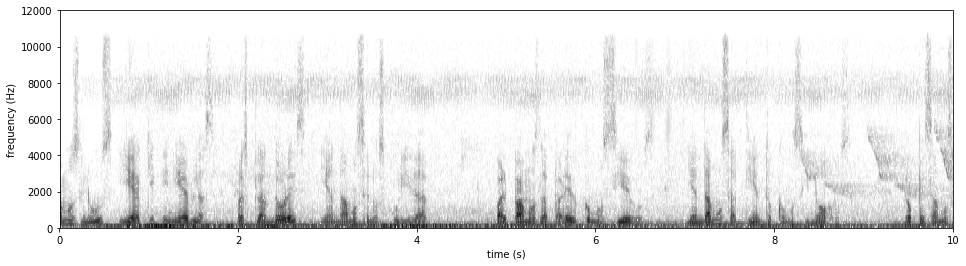

In [28]:
ax = gaussian_spectrogram(flac_data, sampling_frequency)
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)');